### Imports

In [19]:
from KST_utils import *
from DKST_utils import *
from DKST_models import *

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.colors as mcolors
from IPython.display import clear_output

# Display integer series relevant to the dataset
print(f"{num_prosets.items()} \n{num_posets.items()} \n{num_states.items()}")
print(f"Number of possible knowledge structures: \n{[2**(2**Q-2) for Q in [2,3,4,5,6,7]]}")

# Adjust path to config files
path_data = r"C:\Users\...\Deep-Knowledge-Structure_Theory\config\config_data_5_demo.json"  
path_model = r"C:\Users\...\Deep-Knowledge-Structure_Theory\config\config_model_5_demo.json" 

dict_items([(2, 4), (3, 29), (4, 355), (5, 6942), (6, 209527), (7, 9535241), (8, 642779354), (9, 63260289423)]) 
dict_items([(2, 3), (3, 19), (4, 219), (5, 4231), (6, 130023), (7, 6129859), (8, 431723379), (9, 44511042511)]) 
dict_items([(2, 4), (3, 8), (4, 16), (5, 32), (6, 64), (7, 128), (8, 256), (9, 512)])
Number of possible knowledge structures: 
[4, 64, 16384, 1073741824, 4611686018427387904, 85070591730234615865843651857942052864]


### Model and Data

In [39]:
model = SimpleDecoderModel(config_path=path_model)
model.to(model.config["device"]);

device = model.config['device']
input_size = 2 ** model.config['n_items'] 
output_size = 1024
hidden_size1 = output_size
hidden_size2 = output_size
dropout_val = 0.3
regressor = RegressionNetwork(input_size, hidden_size1, hidden_size2, output_size, dropout_val).to(device)

DATASET = DKSTDataset(config_path=path_data)
BS = model.config["BATCH_SIZE_2"]
training_phase = 2
print(f"Dataset: {len(DATASET)}, Batch size: {BS}, Split: {DATASET.config[f'phase_{training_phase}_split']}")

complete_loader = DataLoader(DATASET, batch_size=BS, shuffle=True, collate_fn=collate_fn) 
train_set, val_set, test_set = DATASET.split(DATASET, phase=training_phase)
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BS, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, collate_fn=collate_fn)


100%|██████████| 6942/6942 [00:00<00:00, 56422.33it/s]


Dataset: 6942, Batch size: 32, Split: [0.2, 0.2, 0.6]


In [22]:
# Load models if available
save_dir = "models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

load_path = f"{save_dir}/{model.config['ID_decoder']}.pt"
model.load_state_dict(torch.load(load_path))
model.to(device)

decoder_in_proj_layer = model.input_proj

save_path = f"{save_dir}/{model.config['ID_regressor']}.pt" 
regressor.load_state_dict(torch.load(save_path))
regressor.to(device); 

### Test

Index: 2648, Beta: 0.13, Eta: 0.11, Samples size: 1616


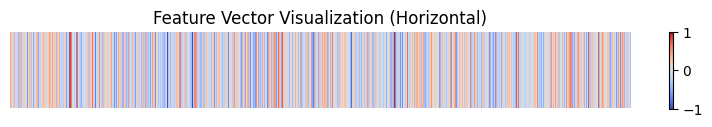

Symmetric Difference of result vs ground truth: 
IITA v1    -> 0 
Prediction -> 0 
(Naive benchmark -> 0)
Prediction is quasi-ordinal: True
Prediction is union-closed: True


In [30]:
idx = random.randint(0, len(DATASET)-1) 
beta = 0.13 # abs(np.random.normal(0.12, 0.06))  
eta = 0.11 #0.05 # abs(np.random.normal(0.12, 0.06))  
samples_size = 1616 #100 # random.randint(80, 300) 
factor=0.4 # factor for calculating std of normal distributions for sampling beta/eta from individually for each item (choose None for fixed beta/eta for all items)
print(f"Index: {idx}, Beta: {beta}, Eta: {eta}, Samples size: {samples_size}")

d_iita, d_dl, quasi_ordinal, union_closed, _, _, d_naiv = DATASET.test_item(idx, model, regressor, samples_size=samples_size, beta=beta, eta=eta, plot="standardized", factor=factor)   ### plot "standardized" or "raw"
print(f"Symmetric Difference of result vs ground truth: \nIITA v1    -> {d_iita} \nPrediction -> {d_dl} \n(Naive benchmark -> {d_naiv})")
print(f"Prediction is quasi-ordinal: {quasi_ordinal}")
print(f"Prediction is union-closed: {union_closed}")

### Evaluation (test phase)

In [32]:
random.seed(None)
np.random.seed(None)
def get_cmap_and_norm(data):
    vmin, vmax = data.min(), data.max()
    abs_max = max(abs(vmin), abs(vmax))

    if vmin < 0 and vmax > 0:
        # Data contains both positive and negative values
        # Use a colormap that goes from green to white to red
        cmap = mcolors.LinearSegmentedColormap.from_list("GdRu", ["red", "white", "green"])
        norm = mcolors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
    elif vmin > 0:
        # only positive values / monotone performance increase (white to gree)
        cmap = mcolors.LinearSegmentedColormap.from_list("WdR", ["white", "green"])
        norm = mcolors.Normalize(vmin=0, vmax=vmax)
    else:
        # only negative values / monotone performance decrease (white to red)
        cmap = mcolors.LinearSegmentedColormap.from_list("WdW", ["white", "red"])
        norm = mcolors.Normalize(vmin=0, vmax=vmax)

    return cmap, norm

Betas = [0.05, 0.1, 0.15] 
Etas = [0.05, 0.1, 0.15] 
Num_samples = [100, 300, 500] 
factor = 0.4

conditions = list(product(Betas, Etas))
sorted_conditions = sorted(conditions, key=lambda x: 0.999*x[0] + 0.998*x[1])
print(f"Evaluation conditions: {sorted_conditions} \n")


diff_lsts_iita = []
diff_lsts_DL = []
diff_lsts_naiv = []
length_diff_lsts_iita = []
length_diff_lsts_DL = []
std_lsts_iita = []
std_lsts_DL = []
ratio_lsts_quasi_ordinal = []
ratio_lsts_u_closed = []
n_simulation_per_condition = 100

for n_samples in Num_samples:
    diff_lst_iita = []
    diff_lst_DL = []
    diff_lst_naiv = []
    length_diff_lst_iita = []
    length_diff_lst_DL = []
    std_lst_iita = []
    std_lst_DL = []
    ratios_quasi_ordinal = []
    ratios_u_closed = []
    
    for beta, eta in sorted_conditions:
        diffs_iita = []
        diffs_DL = []
        diffs_naiv = []
        length_diffs_iita = []
        length_diffs_DL = []
        counts_quasi_ordinal = 0
        counts_u_closed = 0
        for idx in tqdm(np.random.choice(range(len(test_set)), n_simulation_per_condition, replace=False), desc=f"n{str(n_samples)}_b{str(beta)}_e{str(eta)}"):
            original_idx = test_set.indices[idx]
            diff_iita, diff_DL, quasi_ordinal, union_closed, length_diff_iita, length_diff_DL, d_naiv = DATASET.test_item(original_idx, model, regressor, samples_size=n_samples, beta = beta, eta = eta, factor=factor)
            diffs_iita += [diff_iita]
            diffs_DL += [diff_DL]
            diffs_naiv += [d_naiv]
            counts_quasi_ordinal += quasi_ordinal
            counts_u_closed += union_closed
            length_diffs_iita += [length_diff_iita]
            length_diffs_DL += [length_diff_DL]

        diff_lst_iita += [np.mean(diffs_iita)]
        diff_lst_DL += [np.mean(diffs_DL)]
        diff_lst_naiv += [np.mean(diffs_naiv)]
        std_lst_iita += [np.std(diffs_iita)]
        std_lst_DL += [np.std(diffs_DL)]
        ratios_quasi_ordinal += [counts_quasi_ordinal/n_simulation_per_condition]
        ratios_u_closed += [counts_u_closed/n_simulation_per_condition]
        length_diff_lst_iita += [np.mean(length_diffs_iita)]
        length_diff_lst_DL += [np.mean(length_diffs_DL)]

        print(f"N_samples: {n_samples}, Beta: {beta}, Eta: {eta}")
        print(f"Average symmetric difference IITA: {np.mean(diffs_iita)}, (std {np.std(diffs_iita)})")
        print(f"Average symmetric difference DL: {np.mean(diffs_DL)} (std {np.std(diffs_DL)})")
        print(f"Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: {(counts_quasi_ordinal/n_simulation_per_condition):.2f}") 
        print(f"  valid spaces (union-closed): {(counts_u_closed/n_simulation_per_condition):.2f} \n") 
        
    diff_lsts_iita += [diff_lst_iita]
    diff_lsts_DL += [diff_lst_DL]
    diff_lsts_naiv += [diff_lst_naiv]
    std_lsts_iita += [std_lst_iita]
    std_lsts_DL += [std_lst_DL]
    ratio_lsts_quasi_ordinal += [ratios_quasi_ordinal]
    ratio_lsts_u_closed += [ratios_u_closed]
    length_diff_lsts_iita += [length_diff_lst_iita]
    length_diff_lsts_DL += [length_diff_lst_DL]

# Convert lists to numpy arrays and flatten them
diff_lsts_iita_np = np.array(diff_lsts_iita).flatten()
diff_lsts_DL_np = np.array(diff_lsts_DL).flatten()


Evaluation conditions: [(0.05, 0.05), (0.05, 0.1), (0.1, 0.05), (0.05, 0.15), (0.1, 0.1), (0.15, 0.05), (0.1, 0.15), (0.15, 0.1), (0.15, 0.15)] 



n100_b0.05_e0.05: 100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


N_samples: 100, Beta: 0.05, Eta: 0.05
Average symmetric difference IITA: 1.02, (std 1.630828010551695)
Average symmetric difference DL: 1.16 (std 1.5278743403827424)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.84
  valid spaces (union-closed): 0.91 



n100_b0.05_e0.1: 100%|██████████| 100/100 [00:04<00:00, 21.14it/s]


N_samples: 100, Beta: 0.05, Eta: 0.1
Average symmetric difference IITA: 1.95, (std 2.5391927851189244)
Average symmetric difference DL: 1.35 (std 1.5256146302392357)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.85
  valid spaces (union-closed): 0.92 



n100_b0.1_e0.05: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


N_samples: 100, Beta: 0.1, Eta: 0.05
Average symmetric difference IITA: 1.54, (std 2.15137165547936)
Average symmetric difference DL: 1.28 (std 1.4358272876638052)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.86
  valid spaces (union-closed): 0.93 



n100_b0.05_e0.15: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


N_samples: 100, Beta: 0.05, Eta: 0.15
Average symmetric difference IITA: 2.09, (std 2.0644369692485167)
Average symmetric difference DL: 1.67 (std 1.5430813329180026)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.83
  valid spaces (union-closed): 0.91 



n100_b0.1_e0.1: 100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


N_samples: 100, Beta: 0.1, Eta: 0.1
Average symmetric difference IITA: 2.03, (std 1.8517829246431667)
Average symmetric difference DL: 1.39 (std 1.4825316185498372)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.79
  valid spaces (union-closed): 0.91 



n100_b0.15_e0.05: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


N_samples: 100, Beta: 0.15, Eta: 0.05
Average symmetric difference IITA: 1.98, (std 2.1816507511515217)
Average symmetric difference DL: 1.4 (std 1.3564659966250536)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.86
  valid spaces (union-closed): 0.93 



n100_b0.1_e0.15: 100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


N_samples: 100, Beta: 0.1, Eta: 0.15
Average symmetric difference IITA: 3.21, (std 2.9164876135516162)
Average symmetric difference DL: 1.81 (std 1.6534509366775898)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.75
  valid spaces (union-closed): 0.83 



n100_b0.15_e0.1: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


N_samples: 100, Beta: 0.15, Eta: 0.1
Average symmetric difference IITA: 2.69, (std 2.5911194491956557)
Average symmetric difference DL: 2.37 (std 2.0379156017853144)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.72
  valid spaces (union-closed): 0.86 



n100_b0.15_e0.15: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


N_samples: 100, Beta: 0.15, Eta: 0.15
Average symmetric difference IITA: 3.54, (std 2.833443135127296)
Average symmetric difference DL: 2.44 (std 2.065526567246231)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.69
  valid spaces (union-closed): 0.82 



n300_b0.05_e0.05: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


N_samples: 300, Beta: 0.05, Eta: 0.05
Average symmetric difference IITA: 0.79, (std 1.1857065404222074)
Average symmetric difference DL: 0.52 (std 0.7547184905645284)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.97
  valid spaces (union-closed): 0.98 



n300_b0.05_e0.1: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


N_samples: 300, Beta: 0.05, Eta: 0.1
Average symmetric difference IITA: 0.95, (std 1.5451537140362444)
Average symmetric difference DL: 0.52 (std 0.7547184905645283)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.88
  valid spaces (union-closed): 0.93 



n300_b0.1_e0.05: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


N_samples: 300, Beta: 0.1, Eta: 0.05
Average symmetric difference IITA: 0.83, (std 1.378803829411566)
Average symmetric difference DL: 0.67 (std 0.8252878285786117)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.90
  valid spaces (union-closed): 0.96 



n300_b0.05_e0.15: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


N_samples: 300, Beta: 0.05, Eta: 0.15
Average symmetric difference IITA: 1.7, (std 2.414539293529927)
Average symmetric difference DL: 0.79 (std 0.840178552451799)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.82
  valid spaces (union-closed): 0.89 



n300_b0.1_e0.1: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


N_samples: 300, Beta: 0.1, Eta: 0.1
Average symmetric difference IITA: 1.14, (std 1.5685662242952958)
Average symmetric difference DL: 0.84 (std 1.1288932633336068)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.86
  valid spaces (union-closed): 0.92 



n300_b0.15_e0.05: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


N_samples: 300, Beta: 0.15, Eta: 0.05
Average symmetric difference IITA: 1.22, (std 1.664812301732541)
Average symmetric difference DL: 1.14 (std 1.2249081598226048)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.91
  valid spaces (union-closed): 0.96 



n300_b0.1_e0.15: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


N_samples: 300, Beta: 0.1, Eta: 0.15
Average symmetric difference IITA: 1.99, (std 2.2693391108426257)
Average symmetric difference DL: 1.01 (std 1.2449497981846498)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.72
  valid spaces (union-closed): 0.86 



n300_b0.15_e0.1: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


N_samples: 300, Beta: 0.15, Eta: 0.1
Average symmetric difference IITA: 2.35, (std 2.8084693339967237)
Average symmetric difference DL: 1.32 (std 1.2718490476467714)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.81
  valid spaces (union-closed): 0.88 



n300_b0.15_e0.15: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


N_samples: 300, Beta: 0.15, Eta: 0.15
Average symmetric difference IITA: 2.55, (std 2.776238462380348)
Average symmetric difference DL: 1.59 (std 1.4359317532529183)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.75
  valid spaces (union-closed): 0.87 



n500_b0.05_e0.05: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


N_samples: 500, Beta: 0.05, Eta: 0.05
Average symmetric difference IITA: 0.59, (std 1.2577360613419653)
Average symmetric difference DL: 0.37 (std 0.6269768735766894)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.96
  valid spaces (union-closed): 0.97 



n500_b0.05_e0.1: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


N_samples: 500, Beta: 0.05, Eta: 0.1
Average symmetric difference IITA: 0.81, (std 1.5792086625902229)
Average symmetric difference DL: 0.59 (std 0.8377947242612598)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.89
  valid spaces (union-closed): 0.91 



n500_b0.1_e0.05: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


N_samples: 500, Beta: 0.1, Eta: 0.05
Average symmetric difference IITA: 0.76, (std 1.2815615474880635)
Average symmetric difference DL: 0.47 (std 0.6550572494064927)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.91
  valid spaces (union-closed): 0.96 



n500_b0.05_e0.15: 100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


N_samples: 500, Beta: 0.05, Eta: 0.15
Average symmetric difference IITA: 1.83, (std 2.1774067144197016)
Average symmetric difference DL: 0.64 (std 0.9748846085563151)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.93
  valid spaces (union-closed): 0.95 



n500_b0.1_e0.1: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


N_samples: 500, Beta: 0.1, Eta: 0.1
Average symmetric difference IITA: 1.15, (std 1.6393596310755)
Average symmetric difference DL: 0.57 (std 0.9721625378505385)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.90
  valid spaces (union-closed): 0.94 



n500_b0.15_e0.05: 100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


N_samples: 500, Beta: 0.15, Eta: 0.05
Average symmetric difference IITA: 1.38, (std 2.189885841773493)
Average symmetric difference DL: 0.88 (std 1.0322790320451152)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.82
  valid spaces (union-closed): 0.89 



n500_b0.1_e0.15: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


N_samples: 500, Beta: 0.1, Eta: 0.15
Average symmetric difference IITA: 1.58, (std 2.0058913230780977)
Average symmetric difference DL: 0.96 (std 1.1038115781237303)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.80
  valid spaces (union-closed): 0.88 



n500_b0.15_e0.1: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


N_samples: 500, Beta: 0.15, Eta: 0.1
Average symmetric difference IITA: 1.54, (std 2.312660805219823)
Average symmetric difference DL: 1.07 (std 1.274794101021808)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.83
  valid spaces (union-closed): 0.91 



n500_b0.15_e0.15: 100%|██████████| 100/100 [00:12<00:00,  8.29it/s]

N_samples: 500, Beta: 0.15, Eta: 0.15
Average symmetric difference IITA: 2.86, (std 2.7568822970885067)
Average symmetric difference DL: 1.24 (std 1.0688311372709909)
Portion of predicted knowledge structures, which are valid quasi-ordinal spaces: 0.75
  valid spaces (union-closed): 0.89 



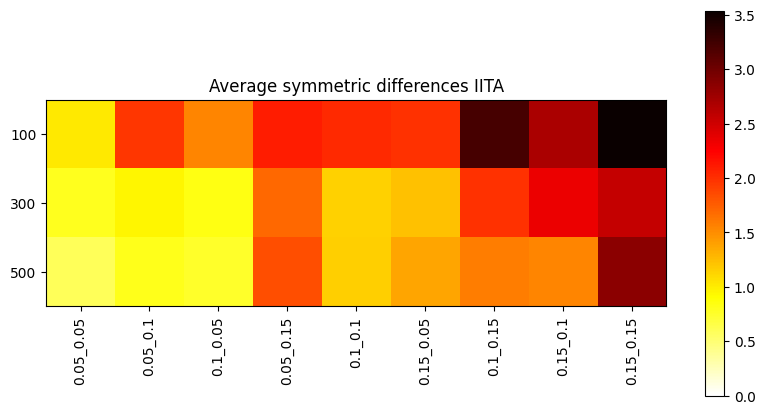

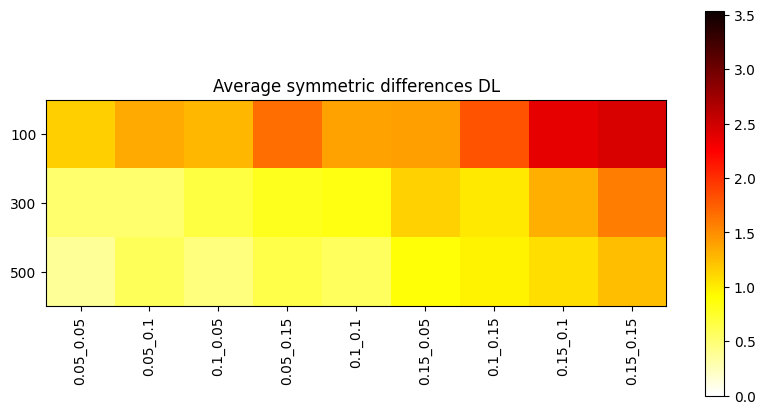

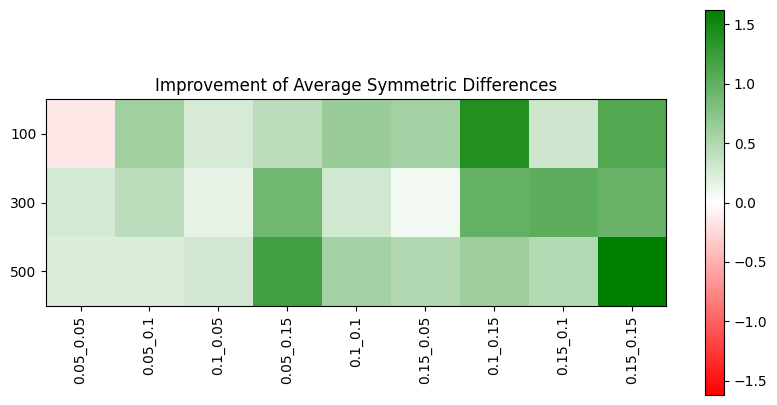

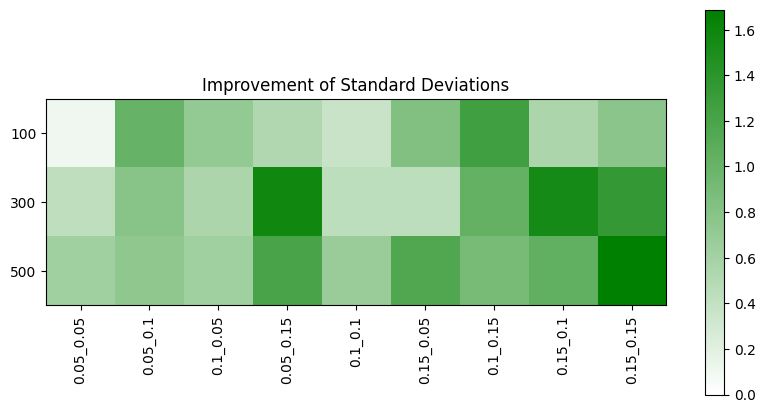

In [33]:
# Find global min and max
vmin = 0 #min(diff_lsts_iita_np.min(), diff_lsts_DL_np.min())
vmax = max(diff_lsts_iita_np.max(), diff_lsts_DL_np.max())

# plot avrg symmetric differences values per condition and number of samples as heatmap for IITA as color map (len(conditions), len(Num_samples))
plt.figure(figsize=(10, 5))
plt.imshow(diff_lsts_iita, cmap='hot_r', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Average symmetric differences IITA")
plt.show()

# plot avrg symmetric differences values per condition and number of samples as heatmap for DL as color map (len(conditions), len(Num_samples))
plt.figure(figsize=(10, 5))
plt.imshow(diff_lsts_DL, cmap='hot_r', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Average symmetric differences DL")
plt.show()

# Calculate the difference between the two data arrays
diff_comparison = np.array(diff_lsts_iita) - np.array(diff_lsts_DL)

# Get the appropriate colormap and normalization for the data
cmap, norm = get_cmap_and_norm(diff_comparison)
plt.figure(figsize=(10, 5))
plt.imshow(diff_comparison, cmap=cmap, norm=norm, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Improvement of Average Symmetric Differences")
plt.show()

# Compare the standard deviations of symmetric differences
std_comparison = np.array(std_lsts_iita) - np.array(std_lsts_DL)
cmap, norm = get_cmap_and_norm(std_comparison)
plt.figure(figsize=(10, 5))
plt.imshow(std_comparison, cmap=cmap, norm=norm, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Improvement of Standard Deviations")
plt.show()

with open(f'logs/Performance-{model.config["ID_regressor"]}', 'wb') as f:
    pickle.dump((sorted_conditions, diff_lsts_iita, diff_lsts_DL, std_lsts_iita, std_lsts_DL), f)

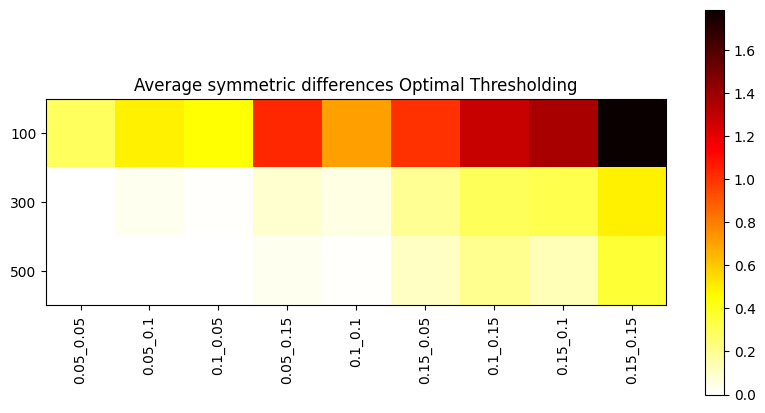

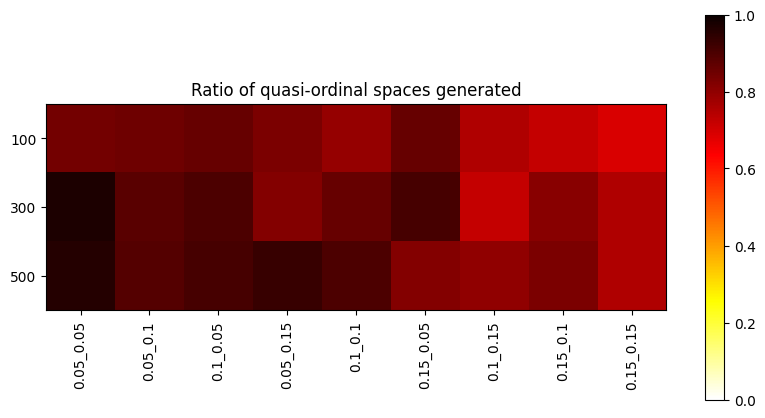

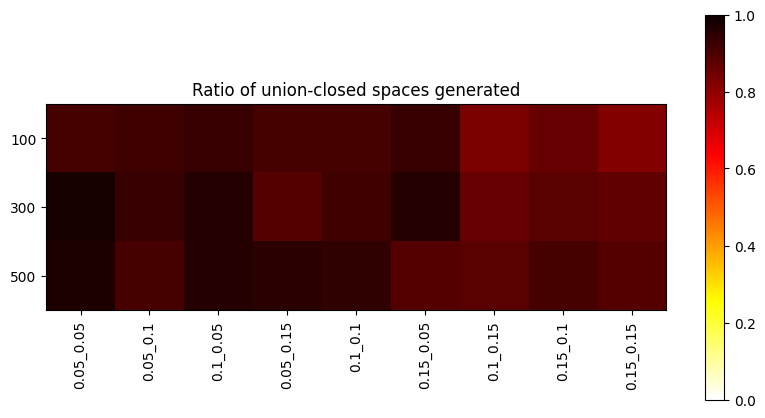

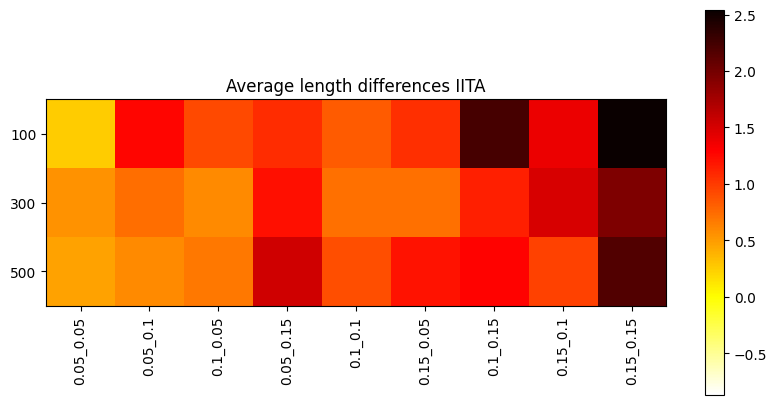

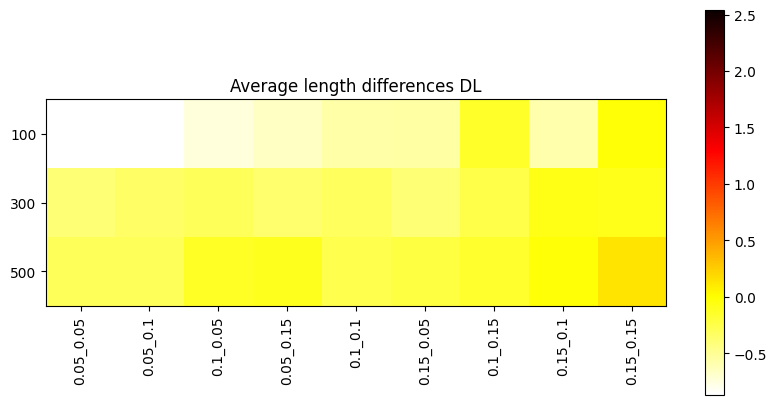

In [36]:
# plot performance of optimal "naive" method
diff_lsts_naiv_np = np.array(diff_lsts_naiv)

# plot avr length diffs 
plt.figure(figsize=(10, 5))
plt.imshow(diff_lsts_naiv_np, cmap='hot_r', interpolation='nearest', vmin=0, vmax=max(diff_lsts_naiv_np.flatten()))
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Average symmetric differences Optimal Thresholding")
plt.show()


# plot heatmap for ratio of quasi-ordinal spaces per condition and number of samples
ratio_lsts_quasi_ordinal_np = np.array(ratio_lsts_quasi_ordinal).reshape(len(Num_samples), len(sorted_conditions))
plt.figure(figsize=(10, 5))
plt.imshow(ratio_lsts_quasi_ordinal_np, cmap='hot_r', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Ratio of quasi-ordinal spaces generated")
plt.show()

# plot heatmap for ratio of union-closed spaces per condition and number of samples
ratio_lsts_u_closed_np = np.array(ratio_lsts_u_closed).reshape(len(Num_samples), len(sorted_conditions))
plt.figure(figsize=(10, 5))
plt.imshow(ratio_lsts_u_closed_np, cmap='hot_r', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Ratio of union-closed spaces generated")
plt.show()


length_diff_lsts_iita_np = np.array(length_diff_lsts_iita)
length_diff_lsts_DL_np = np.array(length_diff_lsts_DL)
# Find global min and max
vmin = min(length_diff_lsts_iita_np.min(), length_diff_lsts_DL_np.min())
vmax = max(length_diff_lsts_iita_np.max(), length_diff_lsts_DL_np.max())

# plot avr length diffs 
plt.figure(figsize=(10, 5))
plt.imshow(length_diff_lsts_iita_np, cmap='hot_r', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Average length differences IITA")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(length_diff_lsts_DL_np, cmap='hot_r', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xticks(range(len(sorted_conditions)), [f"{beta}_{eta}" for beta, eta in sorted_conditions], rotation='vertical')
plt.yticks(range(len(Num_samples)), Num_samples)
plt.title("Average length differences DL")
plt.show()

### Training Phase 1

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=model.config["LR_1"] * model.config['LR_1_decay']**20) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=model.config["LR_1_decay"])
label_smoothing = 0.1
criterion = CustomCELoss(label_smoothing)
criterion2 = nn.MSELoss()

optimizer.zero_grad()
def training(epochs, length_wheight):
    # Training metrics
    train_losses = []
    val_losses = []
    acc_values = []
    logs = []

    for e in range(1, epochs+1):  
        train_losses += [train(model, train_loader, optimizer, criterion, criterion2, scheduler, model.config["clip_norm"], DATASET, length_wheight, device)]
        val_losses += [evaluate(model, val_loader, criterion, device)]
        
        # Display losses, LR and length wheight of current epoch
        log = f"Epoch {e}/{epochs}: Train Losses: {train_losses[-1][-1]:.6f} (CE{train_losses[-1][0]:.6f}) (L{train_losses[-1][1]:.6f}) | Validation Loss: {val_losses[-1]:.6f} | LR: {scheduler.get_last_lr()[0]:.10f} | Length_wheight: {length_wheight:.6f}"
        logs.append(log)
        print(log)
        
        # Evaluate performance on complete dataset sample
        if e % 1 == 0:
            acc, mean_dist, std = performance(model, val_set, DATASET, print_n_errors=1, plot=True)
            acc_values.append(acc)
            logs.append(f"Accuracy: {acc_values[-1]}, Mean distance: {mean_dist}, Std: {std}")
        
        # Decay LR and length wheight 
        scheduler.step()
        length_wheight = max(length_wheight * model.config["length_wheight_decay"], 0.0005)
    
    # save logs to txt file
    dir_name = "logs"
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    with open(f"{dir_name}/logs_{model.config['ID_decoder']}_3.txt", "w") as file:
        for log in logs:
            file.write(log + "\n")

    return train_losses, val_losses, acc_values

In [ ]:
train_losses, val_losses, acc_values = training(300, 0.002);  

In [ ]:
train_losses_total = [float(t[2].cpu().detach()) for t in train_losses]

# plot losses 
plt.plot(train_losses_total, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

### plot losses + accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_losses_total, color=color, label='Training loss')
ax1.plot(val_losses, color='tab:orange', label='Validation loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # second axes shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_values, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])  # accuracy ranges from 0 to 1

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


### Performance test 1

In [37]:
acc, mean_dist, std = performance(model, test_set, DATASET, print_n_errors=1000, plot=False);

# save logs to txt file
# dir_name = "results/Q7"
# with open(f"{dir_name}/performance_Q7__{model.config['ID_decoder']}_3.txt", "w") as file:
#     file.write(f"Accuracy: {acc}, Mean distance: {mean_dist}, Std: {std}") 

Performance test on 1000 random test samples: 100%|██████████| 1000/1000 [00:41<00:00, 24.01it/s]

    Displaying 1000 mismatching sequences:
    163) Symmetric Difference: 2
    [Target]     ||e    |ae   |bc   |bce  |abce |bcde |abcde|<eos>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>||
    [Prediction] ||e    |ae   |bc   |ce   |ace  |bce  |abce |bcde |abcde|<eos>||
    347) Symmetric Difference: 1
    [Target]     ||c    |e    |cd   |ce   |bce  |cde  |acde |bcde |abcde|<eos>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>||
    [Prediction] ||c    |e    |cd   |ce   |cde  |acde |bcde |abcde|<eos>||
    399) Symmetric Difference: 1
    [Target]     ||ac   |be   |bde  |abce |abcde|<eos>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>||
    [Prediction] ||ac   |be   |abe  |bde  |ab

### Embeddings

In [ ]:
# imports 
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
all_embeddings = []
all_generated_sequences = []
kowledge_spaces = []
# create embeddings for the whole dataset
with torch.no_grad():
        for i, (S, _, tgt_seq, _) in enumerate(tqdm(DATASET, desc=f"Generating all sequences and embeddings...")):
            S, tgt_seq = S.to("cuda"), tgt_seq.to("cuda")
            input_matrix = S.unsqueeze(0)
    
            generated_sequence, K_embedding_batch, attention_weights = generate_sequence(model, input_matrix, DATASET, eos_token_id=DATASET.state2idx['<eos>'])
            out_seq_tokens = [DATASET.idx2state[idx] for idx in generated_sequence]
            
            all_generated_sequences.append(generated_sequence)
            all_embeddings.append(K_embedding_batch)
            kowledge_spaces.append([out_seq_tokens])

##### PCA

In [ ]:
# Visualize embeddings with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform([emb.flatten().cpu().numpy() for emb in all_embeddings])

knowledge_spaces2 = [[DATASET.idx2state[idx] for idx in seq] for seq in all_generated_sequences]
knowledge_spaces3 = [seq[:-1] for seq in knowledge_spaces2]

# colors
colors = ['red' if 'bcde' in seq_list else 'blue' for emb, seq_list in zip(all_embeddings, knowledge_spaces2)]

# def all_in(lst1, lst2): # check if all elements of lst1 are in lst2
#     return all([elem in lst2 for elem in lst1])

# incuded_states = ['', 'e', 'ce', 'bce', 'abce', 'abcde', 'abcdef']
# colors = ['red' if all([elem in incuded_states for elem in seq_list]) else 'blue' for emb, seq_list in zip(all_embeddings, knowledge_spaces3)]
# len([1 for c in colors if c == 'red']) 


In [ ]:
pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
pca_df['color'] = colors  # Add the color information
pca_df['size'] = [len(seq) for seq in knowledge_spaces3]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="color",
    size="size", 
    sizes=(20, 200),
    palette=['red', 'blue'],
    data=pca_df,
    legend="brief",
    alpha=0.3
)
plt.show()


##### Interpolation

In [ ]:
idx1 = random.randint(0, len(DATASET)) #44418
idx2 = random.randint(0, len(DATASET)) #14443
S1, _, target1, _ = DATASET[idx1]
S2, _, target2, _ = DATASET[idx2]
S1_np = S1.cpu().numpy().reshape(DATASET.config['max_items'], -1)
S2_np = S2.cpu().numpy().reshape(DATASET.config['max_items'], -1)

K1 = [DATASET.idx2state[idx] for idx in target1.cpu().numpy() if idx != DATASET.state2idx[DATASET.config['PAD_TOKEN']] and idx != DATASET.state2idx[DATASET.config['EOS_TOKEN']]]
K2 = [DATASET.idx2state[idx] for idx in target2.cpu().numpy() if idx != DATASET.state2idx[DATASET.config['PAD_TOKEN']] and idx != DATASET.state2idx[DATASET.config['EOS_TOKEN']]]

print(f"K1 (id {idx1}): {K1} \nK2 (id {idx2}): {K2}")

In [ ]:
K_embeddings = []
for S in [S1, S2]:
    _, K_embedding_batch, _ = generate_sequence(model, S.unsqueeze(0).to('cuda'), DATASET, eos_token_id=DATASET.state2idx['<eos>'])
    K_embeddings.append(K_embedding_batch)

# interpolate between two K_embeddings
intermediate_embeddings = []
N_interpol = 300
for i in list(range(N_interpol+1)):
    alpha = i / N_interpol
    intermediate_embedding = alpha * K_embeddings[0] + (1 - alpha) * K_embeddings[1]
    intermediate_embeddings.append(intermediate_embedding)

# run model on intermediate embeddings (with start token, without input projection)
intermediate_seqs = []
# set all elements of tensor to zero
S = S * 0
for i in list(range(N_interpol+1)):
    # place embeddings into memory cell and run forward pass without projection layer
    precomputed_K_embedding = intermediate_embeddings[i].to('cuda')
    output_seqs, _, _ = generate_sequence(model, S.unsqueeze(0).to('cuda'), DATASET, eos_token_id=DATASET.state2idx['<eos>'], data_embedding=precomputed_K_embedding)
    intermediate_seqs.append(output_seqs)

temp = None
for i, seq in enumerate(intermediate_seqs):
    #print(seq)
    seq_states = [DATASET.idx2state[idx] for idx in seq]
    seq_str = f" >>> Sequence {i}: |" + "|".join([token.ljust(6) for token in seq_states[1:]])
    #print(seq_str)
    
    # display only opon change
    if seq != temp:
        print(seq)
        print(seq_str)
        temp = seq

In [ ]:
padded_sequences = pad_sequences(intermediate_seqs, pad_token=DATASET.state2idx['<pad>'], vocab_size=DATASET.vocab_size)

# Convert arrays to tuples
set1_tuples = set([tuple(arr) for arr in DATASET.encoded])
set2_tuples = set([tuple(arr) for arr in padded_sequences])


common_elements = set1_tuples.intersection(set2_tuples)
# The number of common elements is the answer
num_common_elements = len(common_elements)

print(f"Number of interpolated knowledge structures: {len(set2_tuples)} (both initial structures included)")
print(f"Number of K's in dataset: {len(set1_tuples)}")
print(f"Number of common K's: {num_common_elements}")


##### Embedding Similarity vs Symmetric Difference

In [ ]:
idx1 = random.randint(0, len(DATASET)) #15806
idx2 = random.randint(0, len(DATASET)) #17829
S1, _, target1, _ = DATASET[idx1]
S2, _, target2, _ = DATASET[idx2]
S1_np = S1.cpu().numpy().reshape(DATASET.config['max_items'], -1)
S2_np = S2.cpu().numpy().reshape(DATASET.config['max_items'], -1)

K1 = [DATASET.idx2state[idx] for idx in target1.cpu().numpy() if idx != DATASET.state2idx[DATASET.config['PAD_TOKEN']] and idx != DATASET.state2idx[DATASET.config['EOS_TOKEN']]]
K2 = [DATASET.idx2state[idx] for idx in target2.cpu().numpy() if idx != DATASET.state2idx[DATASET.config['PAD_TOKEN']] and idx != DATASET.state2idx[DATASET.config['EOS_TOKEN']]]
print(f"K1 (id {idx1}): {K1} \nK2 (id {idx2}): {K2}")
# print(S1.reshape(DATASET.config['max_items'], -1))
# print(S2.reshape(DATASET.config['max_items'], -1))

sym_diff = len(set(K1).symmetric_difference(set(K2)))
print(f"Symmetric difference between K1 and K2: {sym_diff}")

K1_embedding = generate_sequence(model, S1.unsqueeze(0).to(model.config["device"]), DATASET, DATASET.config['EOS_TOKEN'], embedding_only=True)[1]
K2_embedding = generate_sequence(model, S2.unsqueeze(0).to(model.config["device"]), DATASET, DATASET.config['EOS_TOKEN'], embedding_only=True)[1]
cosine_distance = F.cosine_similarity(K1_embedding, K2_embedding).item()
euklidean_distance = torch.norm(K1_embedding - K2_embedding, p=2).item()
loss_fn = nn.L1Loss()
mae = loss_fn(K1_embedding, K2_embedding).item()
print(f"Cosine distance between K1 and K2:   {cosine_distance:.2f}")
print(f"Euklidean distance between K1 and K2:   {euklidean_distance:.2f}")
print(f"Mean Absolute distance of embeddings: {mae:.2f}")

In [ ]:
from scipy.stats import pearsonr

def compute_metrics():
    sym_diffs = []
    cosine_distances = []
    distances_euklidean = []
    maes = []
    loss_fn = nn.L1Loss()
    
    for _ in range(10000):
        idx1 = random.randint(0, len(DATASET) - 1)
        idx2 = random.randint(0, len(DATASET) - 1)
        
        S1, _, target1, _ = DATASET[idx1]
        S2, _, target2, _ = DATASET[idx2]
        
        K1 = [DATASET.idx2state[idx] for idx in target1.cpu().numpy()
              if idx != DATASET.state2idx[DATASET.config['PAD_TOKEN']] and
                 idx != DATASET.state2idx[DATASET.config['EOS_TOKEN']]]
        K2 = [DATASET.idx2state[idx] for idx in target2.cpu().numpy()
              if idx != DATASET.state2idx[DATASET.config['PAD_TOKEN']] and
                 idx != DATASET.state2idx[DATASET.config['EOS_TOKEN']]]
        
        sym_diff = len(set(K1).symmetric_difference(set(K2)))
        sym_diffs.append(sym_diff)
        
        K1_embedding = generate_sequence(model, S1.unsqueeze(0).to(model.config["device"]),
                                         DATASET, DATASET.config['EOS_TOKEN'], embedding_only=True)[1]
        K2_embedding = generate_sequence(model, S2.unsqueeze(0).to(model.config["device"]),
                                         DATASET, DATASET.config['EOS_TOKEN'], embedding_only=True)[1]
        cosine_distance = 1 - F.cosine_similarity(K1_embedding, K2_embedding).item() #torch.norm(K1_embedding - K2_embedding, p=2).item()
        cosine_distances.append(cosine_distance)
        
        euklidean = torch.norm(K1_embedding - K2_embedding, p=2).item()
        distances_euklidean.append(euklidean)
        
        # compute mean absolute error between embedding vectors
        mae = loss_fn(K1_embedding, K2_embedding).item()
        maes.append(mae)

    return sym_diffs, cosine_distances, distances_euklidean, maes

# Calculate metrics
sym_diffs, cosine_distances, distances_euklidean, maes = compute_metrics()

# Compute correlation
correlation1, _ = pearsonr(sym_diffs, cosine_distances)
correlation2, _ = pearsonr(sym_diffs, distances_euklidean)
correlation3, _ = pearsonr(sym_diffs, maes)
print(f"Correlation between symmetric differences and Cosine Distances: {correlation1:.3f}")
print(f"Correlation between symmetric differences and Euclidean Distances: {correlation2:.3f}")
print(f"Correlation between symmetric differences and Mean Absolute Distances: {correlation3:.3f}")


### Regression

In [ ]:
# decoder_in_proj_layer = model.input_proj
# train_loader_regressor = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_fn)

input_size = 5 ** 2
output_size = hidden_size1 = hidden_size2 = 1024
dropout_val = 0.3
regressor = RegressionNetwork(input_size, hidden_size1, hidden_size2, output_size, dropout_val).to('cuda')

LR2 = model.config['LR_2'] 
decay_2 = model.config['LR_2_decay']
optimizer_2 = optim.Adam(regressor.parameters(), lr=LR2)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, 1.0, gamma=decay_2)
mse = nn.MSELoss()

In [ ]:
def eval_regressor(regressor, decoder_in_proj, data_loader, criterion, knet=None):
    regressor.eval()
    decoder_in_proj.eval()
    if knet is not None: knet.eval()
    
    # Training metrics
    total_loss = 0.
    total_mse = 0. 
    total_cosine_loss = 0. 
    num_batches = 0

    with torch.no_grad():
        for S, data, _, C in data_loader:
            targets = decoder_in_proj(S)
            outputs = regressor(C)
            
            # Calculate loss
            mse_loss = criterion(outputs, targets) 
            total_mse += mse_loss
            # Calculate cosine loss
            cosine_loss = (1 - F.cosine_similarity(outputs, targets).mean() ** 2) * 0.05
            total_cosine_loss += cosine_loss.item()
            # total
            loss = mse_loss + cosine_loss
            total_loss += loss.item()
            num_batches += 1
    mean_loss = total_loss / num_batches
    mean_cosine_loss = total_cosine_loss / num_batches
    mean_mse_loss = total_mse / num_batches
    
    logs = f"         Validation Loss: {mean_loss} (mean cosine: {mean_cosine_loss}, mean mse: {mean_mse_loss}"
    print(logs)
    return mean_loss, logs

def train_regressor(regressor, decoder_in_proj, train_loader, val_loader, optimizer, criterion, scheduler, epochs):
    decoder_in_proj.eval()
    
    # Training metrics
    train_losses = []
    val_losses = []
    acc_values = []
    diff_values = []
    logs = []
    
    for epoch in range(1, epochs+1):
        
        regressor.train()
    
        total_loss = 0.0
        total_mse = 0.0
        total_cosine_loss = 0.0
        total_l1 = 0.0
        num_batches = 0
        
        for batch_idx, (S, _, _, C) in enumerate(train_loader): 
            outputs = regressor(C)
            targets = decoder_in_proj(S) 
            optimizer.zero_grad()

            ## Calculate loss
            mse_loss = criterion(outputs, targets) 
            total_mse += mse_loss
            ## Calculate cosine loss
            cosine_loss = (1 - F.cosine_similarity(outputs, targets).mean() ** 2) * 0.05
            ## dot_loss = abs(torch.matmul(targets, outputs.t()).mean()) * 0.5
            total_cosine_loss += cosine_loss.item()
            loss = mse_loss + cosine_loss 
            total_loss += loss.item()
            num_batches += 1

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        if epoch % 5 == 0:
            acc, mean_diff, std = performance(model, val_set, DATASET, regressor=regressor, print_n_errors=3, plot=False)
            acc_values += [acc]
            diff_values += [mean_diff]
        
        mean_loss = total_loss / num_batches
        train_losses += [mean_loss]
        mean_cosine_loss = total_cosine_loss / num_batches
        mean_mse_loss = total_mse / num_batches
        
        train_log = f"Epoch: {epoch}/{epochs}, Total Loss: {mean_loss} (mean cosine: {mean_cosine_loss}, mean mse: {mean_mse_loss} | LR: {scheduler.get_last_lr()[0]:.10f}"
        logs += train_log
        print(train_log)
        
        mean_val_loss, val_log = eval_regressor(regressor, decoder_in_proj, val_loader, criterion)
        val_losses += [mean_val_loss]
        logs += [val_log]
    
    return train_losses, val_losses, acc_values, diff_values, logs

In [ ]:
train_losses, val_losses, acc_values, diff_values, logs = train_regressor(regressor, decoder_in_proj_layer, train_loader, val_loader, optimizer_2, mse, scheduler_2, epochs=20)


##### plot losses

In [ ]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_losses, color=color, label='Training loss')
ax1.plot(val_losses, color='tab:orange', label='Validation loss')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_values, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])  # set the range of accuracy axis from 0 to 1
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_losses, color=color, label='Training loss')
ax1.plot(val_losses, color='tab:orange', label='Validation loss')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average symmetric difference', color=color)  # we already handled the x-label with ax1
def moving_average(data_set, periods=10):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')
smooth_diff_values = moving_average(diff_values)
ax2.plot(diff_values, color=color, label='Smooth Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


##### K-net (end-to-end training)

In [ ]:
class KNET(nn.Module):
    def __init__(self, decoder, regressor):
        super(KNET, self).__init__()
        # Define the first fully connected layer
        self.decoder = decoder
        self.regressor = regressor

    def forward(self, S, in_seq, C):
        K_embedding_batch = self.regressor(C)
        output, _, attention_weights = self.decoder(S, in_seq, K_embedding_batch)
        return output, K_embedding_batch, attention_weights

knet = KNET(model, regressor).to('cuda')

In [ ]:
optimizer_3 = optim.Adam(knet.parameters(), lr=0.00001) 
scheduler_3 = torch.optim.lr_scheduler.StepLR(optimizer_3, 1.0, gamma=model.config["LR_2_decay"])

criterion = CustomCELoss()
# def modified_mse(y_pred, y_true): # introduces a tolerance margin to the calculation 
#     diff = y_pred - y_true
#     diff = torch.sign(diff) * torch.clamp(torch.abs(diff) - 0.5, min=0)
#     return (diff ** 2).mean()
criterion2 = nn.MSELoss() # modified_mse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_3.zero_grad()

def end_to_end_training(epochs, length_wheight):
    # Training metrics
    train_losses = []
    val_losses = []
    acc_values = []

    for e in range(1, epochs+1):  
            
        train_losses += [train(model, train_loader, optimizer_3, criterion, criterion2, scheduler_3, model.config["clip_norm"], DATASET, length_wheight, device, knet=knet)]
        val_losses += [evaluate(model, val_loader, criterion, device)]
        
        # Display losses, LR and length wheight of current epoch
        print(f"Epoch {e}/{epochs}: Train Losses: {train_losses[-1][-1]:.6f} (CE{train_losses[-1][0]:.6f}) (L{train_losses[-1][1]:.6f}) | Validation Loss: {val_losses[-1]:.6f} | LR: {scheduler_3.get_last_lr()[0]:.10f} | Length_wheight: {length_wheight:.6f}")
        
        # Evaluate performance on complete dataset sample
        if e % 3 == 0:
            acc, mean_dist, std = performance(model, val_set, DATASET, regressor=regressor, print_n_errors=5, plot=False)
            acc_values.append(acc)
        
        # Decay LR and length wheight 
        scheduler_3.step()
        length_wheight = max(length_wheight * model.config["length_wheight_decay"], 0.02)

    return train_losses, val_losses, acc_values

In [ ]:
train_losses, val_losses, acc_values = end_to_end_training(50, 0.05);

### Performance test 2

In [38]:
performance(model, test_set, DATASET, regressor=regressor, print_n_errors=100, plot=False)

Performance test on 100 random test samples: 100%|██████████| 100/100 [00:04<00:00, 21.72it/s]

    Displaying 100 mismatching sequences:
    0) Symmetric Difference: 3
    [Target]     ||d    |bd   |de   |ade  |bde  |abde |abcde|<eos>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>||
    [Prediction] ||b    |d    |e    |bd   |de   |ade  |bde  |abde |acde |abcde|<eos>||
    2) Symmetric Difference: 4
    [Target]     ||c    |d    |ad   |cd   |acd  |ade  |abde |acde |abcde|<eos>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>||
    [Prediction] ||a    |c    |d    |ac   |ad   |cd   |acd  |ade  |abcd |acde |abcde|<eos>||
    3) Symmetric Difference: 1
    [Target]     ||b    |e    |ae   |be   |abe  |abcde|<eos>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>|<pad>||
    [Prediction] ||e    |ae 

(0.39, 1.3, 1.9999773026846057)